In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 70 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':70}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from time import time
import timeit #imports timeit module
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from lightgbm import LGBMClassifier

In [5]:
df = pd.read_csv('../RiverRoad_Quan_RF.csv')

In [9]:
def GBC(X, y, gridid):
    fig, ax = plt.subplots()

    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_grid = gridid.iloc[train_index]
        test_grid= gridid.iloc[test_index]

        model = GradientBoostingClassifier(n_estimators = 500, 
                                               learning_rate = 0.1, 
                                               max_depth = 4, 
                                               random_state = 2)

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for Light Gradient Boosting Model")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt

## GBC with all 60 columns

5it [07:08, 85.67s/it]


428.34779119999996 seconds
[0.9297736506094022, 0.9332171893147503, 0.9210220673635308, 0.924506387921022, 0.9221835075493612]
0.9261405605516131 accuracy
[[2716  428]
 [ 208 5259]]
              precision    recall  f1-score   support

           0     0.9289    0.8639    0.8952      3144
           1     0.9247    0.9620    0.9430      5467

    accuracy                         0.9261      8611
   macro avg     0.9268    0.9129    0.9191      8611
weighted avg     0.9262    0.9261    0.9255      8611



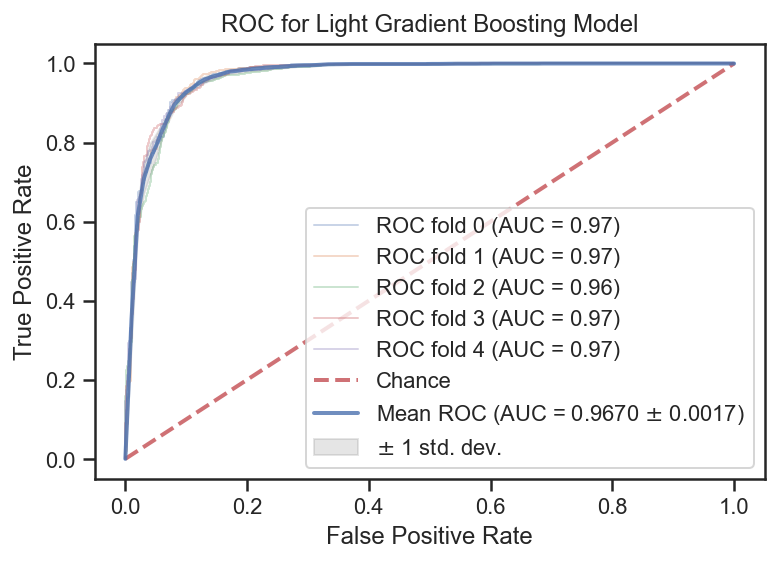

In [14]:
X = df.drop(['GRID_ID', 'wetland_type', 'wetland', 'FID_RiverRd_AOI'], axis=1)
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_60, time_60, cm_60, cr_60, acc_60, roc_60 = GBC(X, y, gridid)
print(f"{time_60} seconds")
print(f"{acc_60}")
print(f"{np.mean(acc_60)} accuracy")
print(cm_60)
print(cr_60)
roc_60.show()

## GBC with Asami's 24 columns(Interpretation)

5it [03:08, 37.71s/it]


188.57770400000004 seconds
[0.9361578641903656, 0.929732868757259, 0.9303135888501742, 0.9256678281068524, 0.9320557491289199]
0.9307855798067143 accuracy
[[2735  409]
 [ 187 5280]]
              precision    recall  f1-score   support

           0     0.9360    0.8699    0.9017      3144
           1     0.9281    0.9658    0.9466      5467

    accuracy                         0.9308      8611
   macro avg     0.9321    0.9179    0.9242      8611
weighted avg     0.9310    0.9308    0.9302      8611



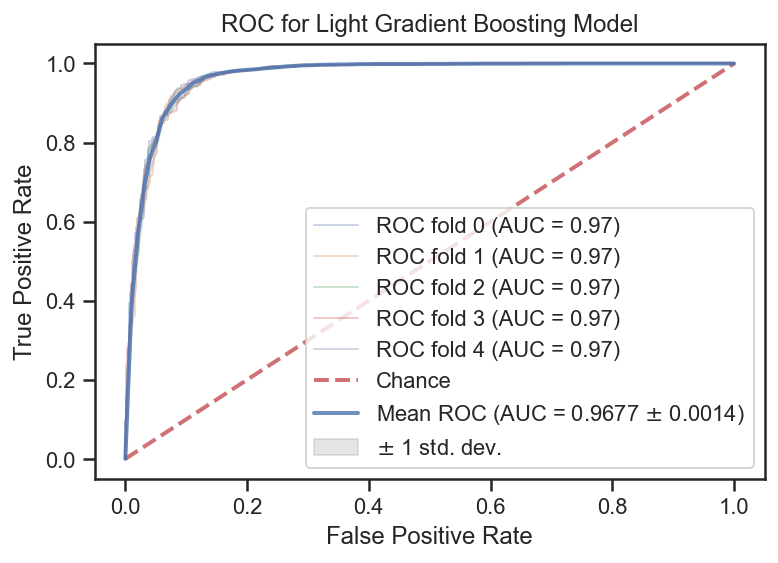

In [13]:
columns = ['qu_dsm_MAX',
'qu_hyddem_MIN',
'qu_dsm_MIN',
'qu_smdem_MAX',
'qu_dem_MIN',
'qu_dsm_SUM',
'qu_dsm_MEAN',
'qu_dsm_RANGE',
'qu_dsm_STD',
'qu_floAcu_MAX',
'qu_floAcu_STD',
'qu_hyddem_MAX',
'qu_dem_MAX',
'qu_floAcu_RANGE',
'qu_curpl_SUM',
'qu_hyddem_SUM',
'qu_curpl_MEAN',
'qu_hyddem_MEAN',
'qu_floAcu_MEAN',
'qu_curpl_STD',
'qu_floAcu_SUM',
'qu_smdem_MIN',
'qu_smdem_SUM',
'qu_curv_STD',
]
X = df[columns]
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_24, time_24, cm_24, cr_24, acc_24, roc_24 = GBC(X, y, gridid)
print(f"{time_24} seconds")
print(f"{acc_24}")
print(f"{np.mean(acc_24)} accuracy")
print(cm_24)
print(cr_24)
roc_24.show()

## GBC with Asami's 12 columns(Prediction)

5it [01:37, 19.45s/it]


97.2677544 seconds
[0.934997098084736, 0.9285714285714286, 0.929732868757259, 0.9227642276422764, 0.9303135888501742]
0.9292758423811748 accuracy
[[2734  410]
 [ 199 5268]]
              precision    recall  f1-score   support

           0     0.9322    0.8696    0.8998      3144
           1     0.9278    0.9636    0.9454      5467

    accuracy                         0.9293      8611
   macro avg     0.9300    0.9166    0.9226      8611
weighted avg     0.9294    0.9293    0.9287      8611



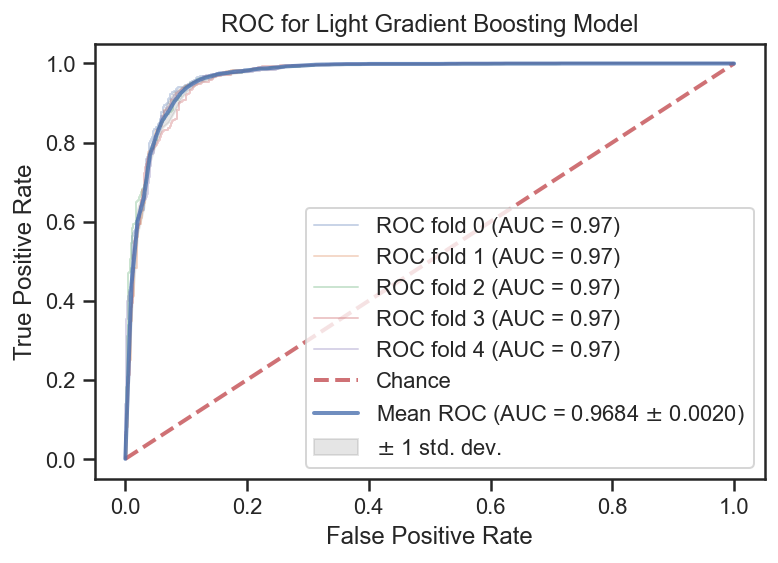

In [12]:
columns = [
'qu_dsm_MAX',
'qu_hyddem_MIN',
'qu_dsm_MIN',
'qu_smdem_MAX',
'qu_dem_MIN',
'qu_dsm_SUM',
'qu_dsm_STD',
'qu_floAcu_MAX',
'qu_floAcu_STD',
'qu_curpl_SUM',
'qu_curpl_STD',
'qu_floAcu_SUM',
]
X = df[columns]
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_12, time_12, cm_12, cr_12, acc_12, roc = GBC(X, y, gridid)
print(f"{time_12} seconds")
print(f"{acc_12}")
print(f"{np.mean(acc_12)} accuracy")
print(cm_12)
print(cr_12)
roc.show()

In [103]:
output_df_60.to_csv("../Comparison Data/GBC60.csv", index=False)
output_df_24.to_csv("../Comparison Data/GBC24.csv", index=False)
output_df_12.to_csv("../Comparison Data/GBC12.csv", index=False)